In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets, models
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
seed = 1024
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
!pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=c2079a8a00951229ff978e9d4e1fafdc9e3436b6e921175455bea559ac148b48
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [6]:
from efficientnet_pytorch import EfficientNet

###Load Data

In [7]:
data_dir = '/content/drive/MyDrive/dlproject/data/output'

train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')
test_dir = os.path.join(data_dir, 'test/')

classes = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']
image_size = (300, 300)
batch_size = 64
num_workers = 2

In [8]:
image_transforms = {
    "train": transforms.Compose([transforms.Resize(image_size), 
                                 transforms.ToTensor(), 
                                 transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                 transforms.RandomRotation(10),
                                 transforms.Normalize([0.4907, 0.4907, 0.4908], [0.2219, 0.2219, 0.2219])]),

    "test": transforms.Compose([transforms.Resize(image_size), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.4907, 0.4907, 0.4908], [0.2219, 0.2219, 0.2219])])
}

train_dataset = datasets.ImageFolder(root = train_dir, transform = image_transforms["train"])
val_dataset = datasets.ImageFolder(root = val_dir, transform = image_transforms["test"])
test_dataset = datasets.ImageFolder(root = test_dir, transform = image_transforms["test"])

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(dataset=val_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers)

###Build and Train Model

In [9]:
def accuracy(output, target):
    _, pred = torch.max(output, dim=-1)
    correct = pred.eq(target).sum() * 1.0
    return correct / target.shape[0]


def fit(epoch, train_loader, val_loader, model, optimizer, criterion, scheduler):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    model.train()
    for idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target = target.cuda()

        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        batch_acc = accuracy(out, target)
        train_loss += loss.item() * data.size(0)
        train_acc += batch_acc.item() * data.size(0)
    if scheduler: scheduler.step()

    model.eval()
    with torch.no_grad():
        for idx, (data, target) in enumerate(val_loader):
            data = data.cuda()
            target = target.cuda()

            out = model(data)
            loss = criterion(out, target)

            batch_acc = accuracy(out, target)
            val_loss += loss.item() * data.size(0)
            val_acc += batch_acc.item() * data.size(0)

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    # print training/validation statistics 
    print('Epoch: {}\tloss: {:.6f}\taccuracy: {:.6f}\tval_loss: {:.6f}\tval_accuracy: {:.6f}'
          .format(epoch+1, train_loss, train_acc, val_loss, val_acc))
    return train_loss, train_acc, val_loss, val_acc


def test(test_loader, model, criterion):
    test_loss = 0
    test_acc = 0
    num_class = 4
    cm = torch.zeros(num_class, num_class)

    model.eval()
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_loader):
            data = data.cuda()
            target = target.cuda()

            out = model(data)
            loss = criterion(out, target)

            batch_acc = accuracy(out, target)
            test_loss += loss.item() * data.size(0)
            test_acc += batch_acc.item() * data.size(0)

            # update confusion matrix
            _, preds = torch.max(out, 1)
            for t, p in zip(target.view(-1), preds.view(-1)):
                cm[t.long(), p.long()] += 1

    test_loss /= len(test_loader.dataset)
    test_acc /= len(test_loader.dataset)
    print("Test loss:", test_loss)
    print("Test accuracy:", test_acc)
    print(cm.int())
    cm_percent = cm / cm.sum(1)
    per_cls_acc = cm_percent.diag().detach().numpy().tolist()
    for i, acc_i in enumerate(per_cls_acc):
        print("Accuracy of Class {}: {:.4f}".format(i, acc_i))
    return cm

In [10]:
def plot_loss_acc(hist, name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    plt.suptitle(name + ': Accuracy/Loss vs Epoch')
    x = np.arange(1, len(hist['loss'])+1, 1)
    ax1.plot(x, hist['acc'])
    ax1.plot(x, hist['val_acc'])
    ax2.plot(x, hist['loss'])
    ax2.plot(x, hist['val_loss'])
    ax1.set(xlabel='Epoch', ylabel='Accuracy', ylim=(0,1))
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax1.legend(['Training', 'Validation'])
    ax2.legend(['Training', 'Validation'])

def plot_confusion_matrix(cm):
    cm = cm.numpy().astype('int')
    plt.figure(figsize=(10,8))
    g = sns.heatmap(cm, 
                    cmap="YlGnBu", 
                    annot=True, 
                    fmt="d", 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    square=True, 
                    linewidth=1)
    plt.yticks(rotation=0)
    g.xaxis.tick_top()
    g.xaxis.set_label_position('top')

In [11]:
def train(model, criterion, optimizer, n_epochs, patience, name, scheduler=None):
    
    model.cuda()
    not_improved = 0
    val_loss_min = np.Inf
    hist = {}

    for epoch in range(n_epochs):

        # train loop
        train_loss, train_acc, val_loss, val_acc = fit(epoch, train_loader, val_loader, model, optimizer, criterion, scheduler)
        hist['loss'] = hist.get('loss', []) + [train_loss]
        hist['acc'] = hist.get('acc', []) + [train_acc]
        hist['val_loss'] = hist.get('val_loss', []) + [val_loss]
        hist['val_acc'] = hist.get('val_acc', []) + [val_acc]
        
        if val_loss < val_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(val_loss_min, val_loss))
            torch.save(model.state_dict(), '/content/drive/MyDrive/dlproject/weights/'+name+'.pth')
            val_loss_min = val_loss
            not_improved = 0
        else:
            not_improved += 1
            if not_improved == patience:
                print('Early stopping ...')
                break
    return hist

In [12]:
model_name = 'efficientnet-b3'
model = EfficientNet.from_pretrained(model_name)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

# Replace last layer
num_ftrs = model._fc.in_features
print(num_ftrs)

last_layers = nn.Sequential(
                            nn.BatchNorm1d(num_features=num_ftrs),    
                            nn.Linear(num_ftrs, num_ftrs),
                            nn.ReLU(),
                            nn.BatchNorm1d(num_features=num_ftrs),  
                            nn.Linear(num_ftrs, 256),
                            nn.ReLU(),
                            nn.BatchNorm1d(num_features=256),
                            nn.Dropout(0.2),
                            nn.Linear(256, 4)
                            )
model._fc = last_layers

params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3
1536
	 _fc.0.weight
	 _fc.0.bias
	 _fc.1.weight
	 _fc.1.bias
	 _fc.3.weight
	 _fc.3.bias
	 _fc.4.weight
	 _fc.4.bias
	 _fc.6.weight
	 _fc.6.bias
	 _fc.8.weight
	 _fc.8.bias


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=0.1, momentum=0.9, weight_decay=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

n_epochs = 100
patience = 10
hist = train(model, criterion, optimizer, n_epochs, patience, model_name, scheduler)

Epoch: 1	loss: 0.856023	accuracy: 0.717183	val_loss: 0.783207	val_accuracy: 0.733297
Validation loss decreased (inf --> 0.783207).  Saving model ...
Epoch: 2	loss: 0.639460	accuracy: 0.759551	val_loss: 0.712404	val_accuracy: 0.679522
Validation loss decreased (0.783207 --> 0.712404).  Saving model ...
Epoch: 3	loss: 0.529695	accuracy: 0.791237	val_loss: 0.653357	val_accuracy: 0.743074
Validation loss decreased (0.712404 --> 0.653357).  Saving model ...
Epoch: 4	loss: 0.489069	accuracy: 0.798117	val_loss: 0.537100	val_accuracy: 0.776752
Validation loss decreased (0.653357 --> 0.537100).  Saving model ...
Epoch: 5	loss: 0.457445	accuracy: 0.814050	val_loss: 0.544354	val_accuracy: 0.795220
Epoch: 6	loss: 0.436107	accuracy: 0.820387	val_loss: 0.470972	val_accuracy: 0.818034
Validation loss decreased (0.537100 --> 0.470972).  Saving model ...
Epoch: 7	loss: 0.431264	accuracy: 0.827268	val_loss: 0.486913	val_accuracy: 0.807713
Epoch: 8	loss: 0.409361	accuracy: 0.831070	val_loss: 0.415728	val

Test loss: 0.40106015052816096
Test accuracy: 0.8340563997141451
tensor([[248,   4,   5,   0],
        [  1, 623,  16,  14],
        [  2,  14, 492,  93],
        [  3,  20, 134, 175]], dtype=torch.int32)
Accuracy of Class 0: 0.9650
Accuracy of Class 1: 0.9526
Accuracy of Class 2: 0.8186
Accuracy of Class 3: 0.5271


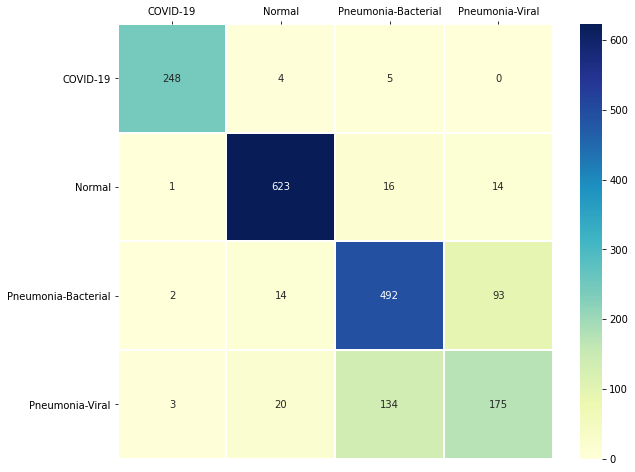

In [14]:
weights_path = '/content/drive/MyDrive/dlproject/weights/'+model_name+'.pth'

model.load_state_dict(torch.load(weights_path))

cm = test(test_loader, model, criterion)

plot_confusion_matrix(cm)

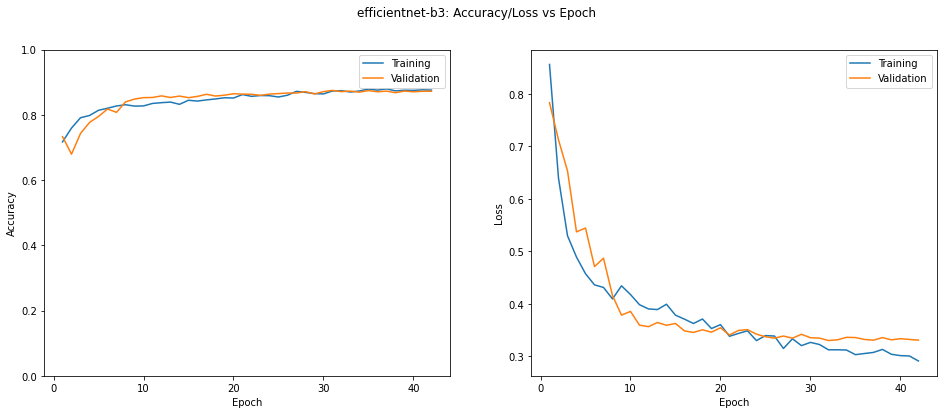

In [15]:
plot_loss_acc(hist, model_name)

###Focal Loss

In [16]:
class FocalLoss(nn.Module):
    def __init__(self, cls_num_list, beta, gamma):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        per_cls_weights = (1 - beta) / (1 - beta ** torch.tensor(cls_num_list))
        per_cls_weights *= len(cls_num_list) / torch.sum(per_cls_weights)
        self.weight = per_cls_weights.cuda()

    def forward(self, input, target):
        focal_loss = None
        N = input.shape[0]
        probs = torch.softmax(input, dim=1)
        probs_target = probs[range(N), target]
        L = -(1 - probs_target) ** self.gamma * torch.log(probs_target)
        focal_loss = torch.mean(self.weight[target] * L)
        return focal_loss

In [17]:
unique, frequency = np.unique(train_dataset.targets, return_counts=True)
print(unique)
print(frequency)

[0 1 2 3]
[ 768 1962 1800  993]


In [18]:
model_name = 'efficientnet-b3'
model = EfficientNet.from_pretrained(model_name)
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

# Replace last layer
num_ftrs = model._fc.in_features
print(num_ftrs)

last_layers = nn.Sequential(
                            nn.BatchNorm1d(num_features=num_ftrs),    
                            nn.Linear(num_ftrs, num_ftrs),
                            nn.ReLU(),
                            nn.BatchNorm1d(num_features=num_ftrs),  
                            nn.Linear(num_ftrs, 256),
                            nn.ReLU(),
                            nn.BatchNorm1d(num_features=256),
                            nn.Dropout(0.2),
                            nn.Linear(256, 4)
                            )
model._fc = last_layers

params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Loaded pretrained weights for efficientnet-b3
1536
	 _fc.0.weight
	 _fc.0.bias
	 _fc.1.weight
	 _fc.1.bias
	 _fc.3.weight
	 _fc.3.bias
	 _fc.4.weight
	 _fc.4.bias
	 _fc.6.weight
	 _fc.6.bias
	 _fc.8.weight
	 _fc.8.bias


In [19]:
criterion = FocalLoss(cls_num_list=list(frequency), beta=0.9999, gamma=3)
optimizer = optim.SGD(params_to_update, lr=0.1, momentum=0.9, weight_decay=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

n_epochs = 100
patience = 10
hist = train(model, criterion, optimizer, n_epochs, patience, model_name, scheduler)

Epoch: 1	loss: 0.452475	accuracy: 0.670650	val_loss: 0.435178	val_accuracy: 0.570885
Validation loss decreased (inf --> 0.435178).  Saving model ...
Epoch: 2	loss: 0.255444	accuracy: 0.707224	val_loss: 0.165078	val_accuracy: 0.688756
Validation loss decreased (0.435178 --> 0.165078).  Saving model ...
Epoch: 3	loss: 0.183452	accuracy: 0.726417	val_loss: 0.322910	val_accuracy: 0.561651
Epoch: 4	loss: 0.140529	accuracy: 0.743437	val_loss: 0.159366	val_accuracy: 0.626833
Validation loss decreased (0.165078 --> 0.159366).  Saving model ...
Epoch: 5	loss: 0.136789	accuracy: 0.762267	val_loss: 0.154794	val_accuracy: 0.745790
Validation loss decreased (0.159366 --> 0.154794).  Saving model ...
Epoch: 6	loss: 0.112279	accuracy: 0.769690	val_loss: 0.133246	val_accuracy: 0.712656
Validation loss decreased (0.154794 --> 0.133246).  Saving model ...
Epoch: 7	loss: 0.102670	accuracy: 0.784900	val_loss: 0.110036	val_accuracy: 0.731668
Validation loss decreased (0.133246 --> 0.110036).  Saving model 

Test loss: 0.08538818312505837
Test accuracy: 0.8188720181293446
tensor([[251,   1,   4,   1],
        [  5, 613,   8,  28],
        [  4,  15, 447, 135],
        [  4,  16, 113, 199]], dtype=torch.int32)
Accuracy of Class 0: 0.9767
Accuracy of Class 1: 0.9373
Accuracy of Class 2: 0.7438
Accuracy of Class 3: 0.5994


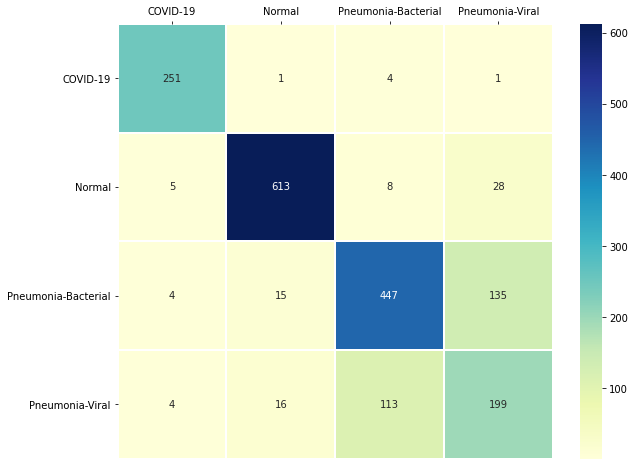

In [20]:
weights_path = '/content/drive/MyDrive/dlproject/weights/'+model_name+'.pth'

model.load_state_dict(torch.load(weights_path))

cm = test(test_loader, model, criterion)

plot_confusion_matrix(cm)

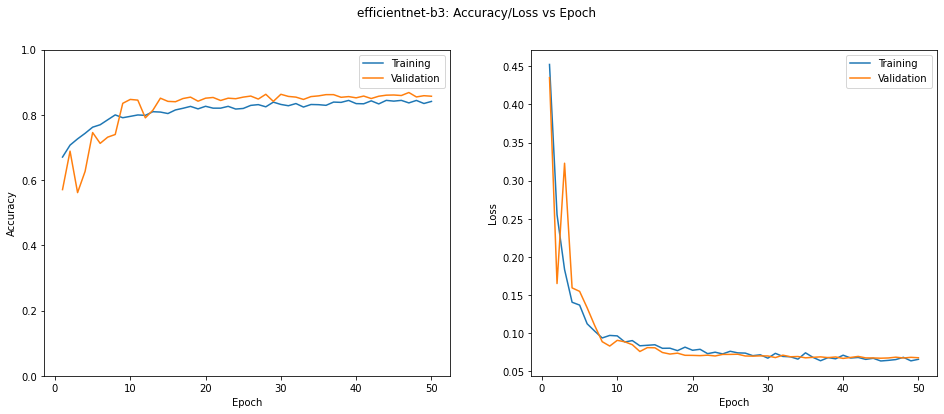

In [21]:
plot_loss_acc(hist, model_name)